<a href="https://colab.research.google.com/github/codekshitij/NLP2SQL/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'human-stress-detection-in-and-through-sleep:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1936400%2F3189060%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240211%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240211T015424Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4f4e5e8d1b23ef2a2f2448411b2f63a195439686507c95b6963896adc53471808494a2ee79dd552b387096e8a0b5cfb55d5e31c088cf45ab89ee5e1afb4c55f1a681a785228d0782e60cb6209ed231d1e422501aab9884f9d65eb654b2f4a377ade79c5863b191a90d647c39de1c9ce108fe9eb38de556c349bdc8d69f7120cb38cbcbb37da905a4ff64a0e7a45a3e4144ba6a360f8fce84c62afbc5cef6cab2eccc2648fccefed0b62556ed0dc1a0c0985313b350685a139dcccec7fca2256795304d8c0930b45aa5ff94872228271f74716ca1051f3120b460678128d705a301a81eee63b6be58153d57094839ebe24b559dbba5fa86eb7375d2f77f5d5e11'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 3022697 bytes downloaded
Downloaded and uncompressed: human-stress-detection-in-and-through-sleep
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/human-stress-detection-in-and-through-sleep/IEEE-TCE_2020-08-0175_SaYoPillow.pdf
/kaggle/input/human-stress-detection-in-and-through-sleep/readme.docx
/kaggle/input/human-stress-detection-in-and-through-sleep/SaYoPillow.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline



In [4]:
data = pd.read_csv('/kaggle/input/human-stress-detection-in-and-through-sleep/SaYoPillow.csv')
data.head()

,sr,rr,t,lm,bo,rem,sr.1,hr,sl
0,93.80,25.680,91.840,16.600,89.840,99.60,1.840,74.20,3
1,91.64,25.104,91.552,15.880,89.552,98.88,1.552,72.76,3
2,60.00,20.000,96.000,10.000,95.000,85.00,7.000,60.00,1
3,85.76,23.536,90.768,13.920,88.768,96.92,0.768,68.84,3
4,48.12,17.248,97.872,6.496,96.248,72.48,8.248,53.12,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630 entries, 0 to 629
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sr      630 non-null    float64
 1   rr      630 non-null    float64
 2   t       630 non-null    float64
 3   lm      630 non-null    float64
 4   bo      630 non-null    float64
 5   rem     630 non-null    float64
 6   sr.1    630 non-null    float64
 7   hr      630 non-null    float64
 8   sl      630 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 44.4 KB


In [6]:
data.describe()

,sr,rr,t,lm,bo,rem,sr.1,hr,sl
count,630.000000,630.000000,630.00000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000
mean,71.600000,21.800000,92.80000,11.700000,90.900000,88.500000,3.700000,64.500000,2.000000
std,19.372833,3.966111,3.52969,4.299629,3.902483,11.893747,3.054572,9.915277,1.415337
min,45.000000,16.000000,85.00000,4.000000,82.000000,60.000000,0.000000,50.000000,0.000000
25%,52.500000,18.500000,90.50000,8.500000,88.500000,81.250000,0.500000,56.250000,1.000000
50%,70.000000,21.000000,93.00000,11.000000,91.000000,90.000000,3.500000,62.500000,2.000000
75%,91.250000,25.000000,95.50000,15.750000,94.250000,98.750000,6.500000,72.500000,3.000000
max,100.000000,30.000000,99.00000,19.000000,97.000000,105.000000,9.000000,85.000000,4.000000


In [7]:
data['sl'].value_counts()

3    126
1    126
0    126
2    126
4    126
Name: sl, dtype: int64

# snoring range of the user,
# respiration rate,
# body temperature,
# limb movement rate,
# blood oxygen levels,
# eye movement,
# number of hours of sleep,
# heart rate and Stress Levels (0- low/normal, 1 – medium low, 2- medium, 3-medium high, 4 -high)

In [8]:
data.rename({'sr':'SnoringRate',
            'rr':'RespirationRate',
            't':'BodyTemperature',
            'lm':'LimbMovement',
            'bo':'BloodOxygen',
            'rem':'RapidEyeMovement',
            'sr.1':'SleepingHours',
            'hr':'HeartRate',
            'sl':'StressLevel'}, axis=1, inplace=True)

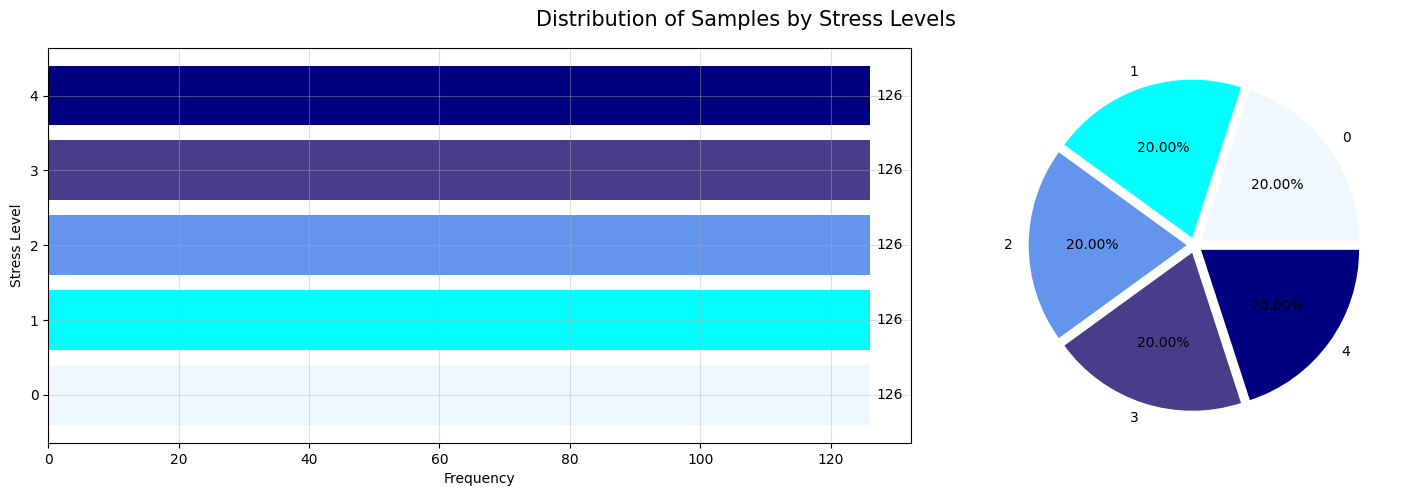

In [9]:
stress = data['StressLevel'].value_counts().sort_index()
colors = ['aliceblue','aqua','cornflowerblue','darkslateblue','navy']

figure, axes = plt.subplots(1,2, figsize=(15,5), gridspec_kw={'width_ratios':[1.5,1]})
axes[0].barh(y=stress.index.astype(str), width=stress.values, color=colors)
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Stress Level')

for index, values in enumerate(stress):
    axes[0].text(values+1, index, str(values), va='center')

axes[0].grid(alpha=0.4)
axes[1].pie(stress.values, labels=stress.index, autopct='%.2f%%', colors=colors, explode=([0.05]*len(stress.index)))
figure.suptitle('Distribution of Samples by Stress Levels', fontsize=15)
plt.tight_layout(pad=1)
plt.show()


,count,mean,std,min,25%,50%,75%,max
StressLevel,,,,,,,,
0,126.0,47.5,1.460685,45.0,46.25,47.5,48.75,50.0
1,126.0,55.0,2.921370,50.0,52.50,55.0,57.50,60.0
2,126.0,70.0,5.842739,60.0,65.00,70.0,75.00,80.0
3,126.0,87.5,4.382054,80.0,83.75,87.5,91.25,95.0
4,126.0,98.0,1.168548,96.0,97.00,98.0,99.00,100.0


<ipython-input-10-73e5f43e536f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, y=data['SnoringRate'], x=data['StressLevel'], palette=colors)


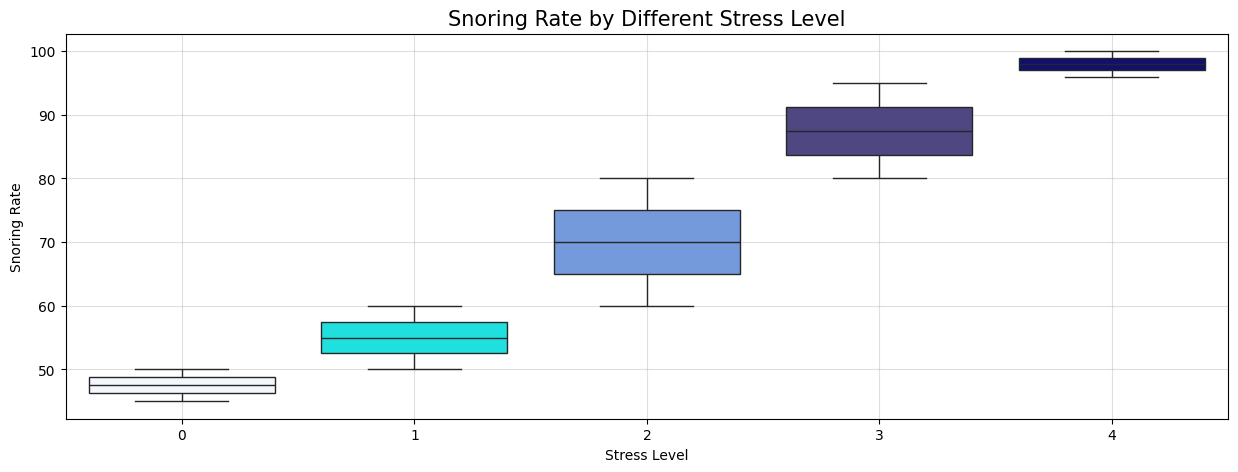

In [10]:
display(data.groupby('StressLevel').SnoringRate.describe())
plt.figure(figsize=(15,5))
sns.boxplot(data=data, y=data['SnoringRate'], x=data['StressLevel'], palette=colors)
plt.xlabel('Stress Level')
plt.ylabel('Snoring Rate')
plt.title('Snoring Rate by Different Stress Level', fontsize=15)
plt.grid(alpha=0.4)
plt.show()

,count,mean,std,min,25%,50%,75%,max
StressLevel,,,,,,,,
0,126.0,47.5,1.460685,45.0,46.25,47.5,48.75,50.0
1,126.0,55.0,2.921370,50.0,52.50,55.0,57.50,60.0
2,126.0,70.0,5.842739,60.0,65.00,70.0,75.00,80.0
3,126.0,87.5,4.382054,80.0,83.75,87.5,91.25,95.0
4,126.0,98.0,1.168548,96.0,97.00,98.0,99.00,100.0


<ipython-input-11-cf6722b33899>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, y=data['BodyTemperature'], x=data['StressLevel'], palette=colors)


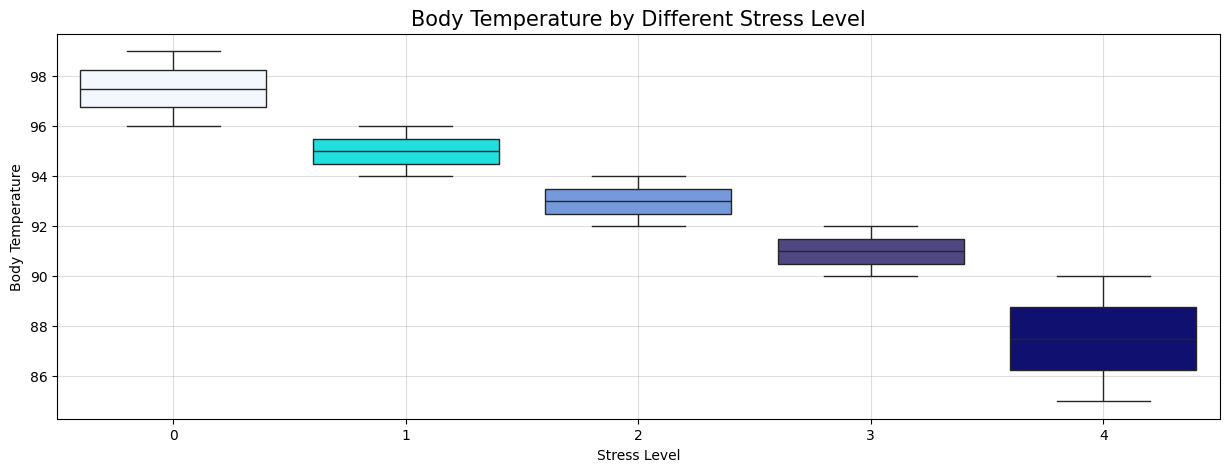

In [11]:
display(data.groupby('StressLevel').SnoringRate.describe())
plt.figure(figsize=(15,5))
sns.boxplot(data=data, y=data['BodyTemperature'], x=data['StressLevel'], palette=colors)
plt.xlabel('Stress Level')
plt.ylabel('Body Temperature')
plt.title('Body Temperature by Different Stress Level', fontsize=15)
plt.grid(alpha=0.4)
plt.show()

,count,mean,std,min,25%,50%,75%,max
StressLevel,,,,,,,,
0,126.0,47.5,1.460685,45.0,46.25,47.5,48.75,50.0
1,126.0,55.0,2.921370,50.0,52.50,55.0,57.50,60.0
2,126.0,70.0,5.842739,60.0,65.00,70.0,75.00,80.0
3,126.0,87.5,4.382054,80.0,83.75,87.5,91.25,95.0
4,126.0,98.0,1.168548,96.0,97.00,98.0,99.00,100.0


<ipython-input-12-128d67b3b7f9>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, y=data['LimbMovement'], x=data['StressLevel'], palette=colors)


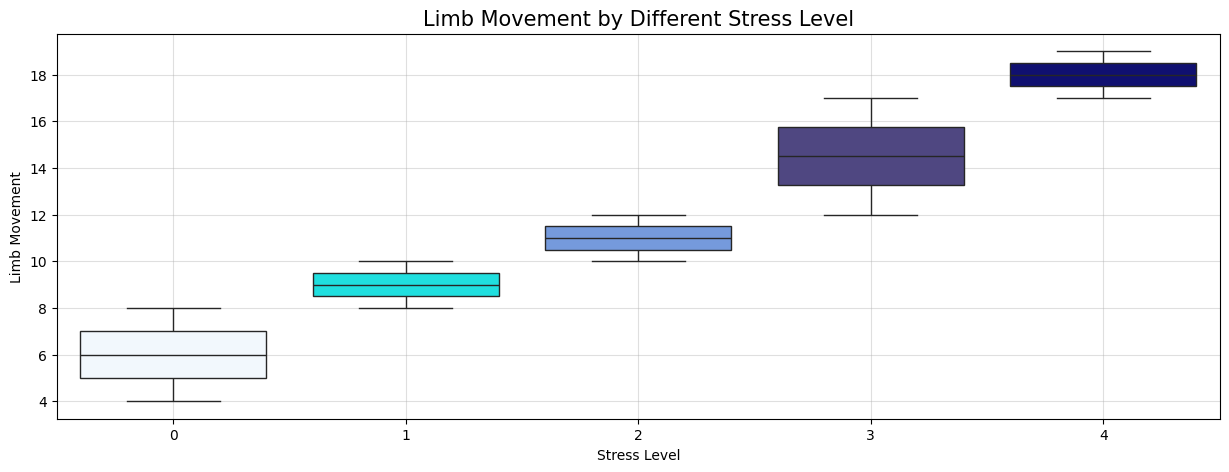

In [12]:
display(data.groupby('StressLevel').SnoringRate.describe())
plt.figure(figsize=(15,5))
sns.boxplot(data=data, y=data['LimbMovement'], x=data['StressLevel'], palette=colors)
plt.xlabel('Stress Level')
plt.ylabel('Limb Movement')
plt.title('Limb Movement by Different Stress Level', fontsize=15)
plt.grid(alpha=0.4)
plt.show()

,count,mean,std,min,25%,50%,75%,max
StressLevel,,,,,,,,
0,126.0,47.5,1.460685,45.0,46.25,47.5,48.75,50.0
1,126.0,55.0,2.921370,50.0,52.50,55.0,57.50,60.0
2,126.0,70.0,5.842739,60.0,65.00,70.0,75.00,80.0
3,126.0,87.5,4.382054,80.0,83.75,87.5,91.25,95.0
4,126.0,98.0,1.168548,96.0,97.00,98.0,99.00,100.0


<ipython-input-13-188ad6f91390>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, y=data['BloodOxygen'], x=data['StressLevel'], palette=colors)


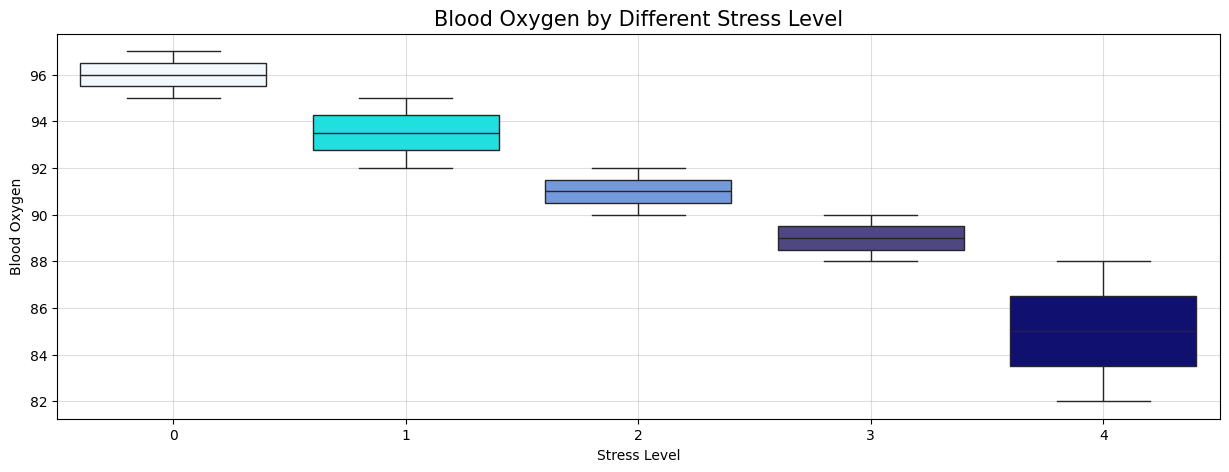

In [13]:
display(data.groupby('StressLevel').SnoringRate.describe())
plt.figure(figsize=(15,5))
sns.boxplot(data=data, y=data['BloodOxygen'], x=data['StressLevel'], palette=colors)
plt.xlabel('Stress Level')
plt.ylabel('Blood Oxygen')
plt.title('Blood Oxygen by Different Stress Level', fontsize=15)
plt.grid(alpha=0.4)
plt.show()

,count,mean,std,min,25%,50%,75%,max
StressLevel,,,,,,,,
0,126.0,47.5,1.460685,45.0,46.25,47.5,48.75,50.0
1,126.0,55.0,2.921370,50.0,52.50,55.0,57.50,60.0
2,126.0,70.0,5.842739,60.0,65.00,70.0,75.00,80.0
3,126.0,87.5,4.382054,80.0,83.75,87.5,91.25,95.0
4,126.0,98.0,1.168548,96.0,97.00,98.0,99.00,100.0


<ipython-input-14-dd987213bbf3>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, y=data['RapidEyeMovement'], x=data['StressLevel'], palette=colors)


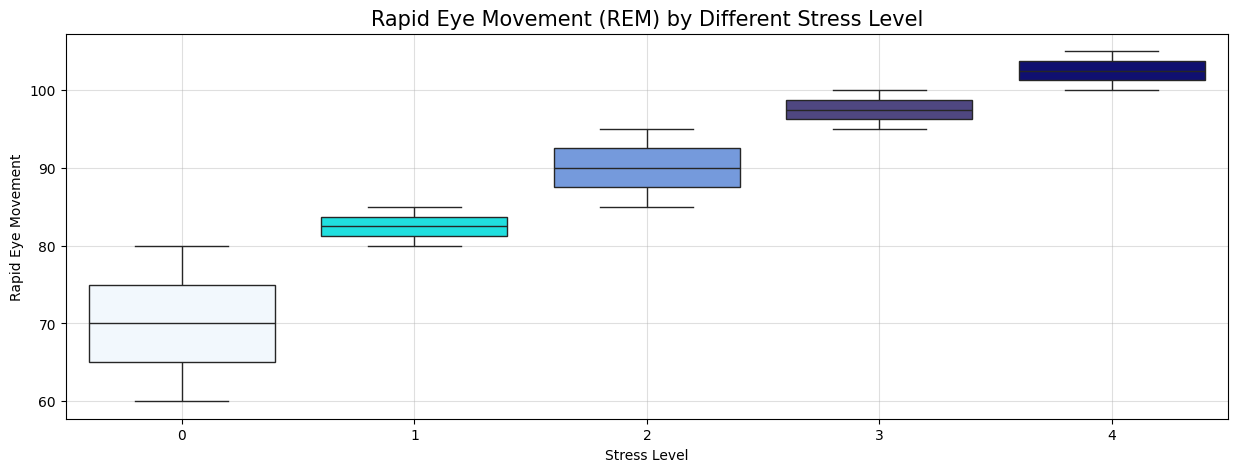

In [14]:
display(data.groupby('StressLevel').SnoringRate.describe())
plt.figure(figsize=(15,5))
sns.boxplot(data=data, y=data['RapidEyeMovement'], x=data['StressLevel'], palette=colors)
plt.xlabel('Stress Level')
plt.ylabel('Rapid Eye Movement')
plt.title('Rapid Eye Movement (REM) by Different Stress Level', fontsize=15)
plt.grid(alpha=0.4)
plt.show()


,count,mean,std,min,25%,50%,75%,max
StressLevel,,,,,,,,
0,126.0,47.5,1.460685,45.0,46.25,47.5,48.75,50.0
1,126.0,55.0,2.921370,50.0,52.50,55.0,57.50,60.0
2,126.0,70.0,5.842739,60.0,65.00,70.0,75.00,80.0
3,126.0,87.5,4.382054,80.0,83.75,87.5,91.25,95.0
4,126.0,98.0,1.168548,96.0,97.00,98.0,99.00,100.0


<ipython-input-15-e610959d4bae>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, y=data['SleepingHours'], x=data['StressLevel'], palette=colors)


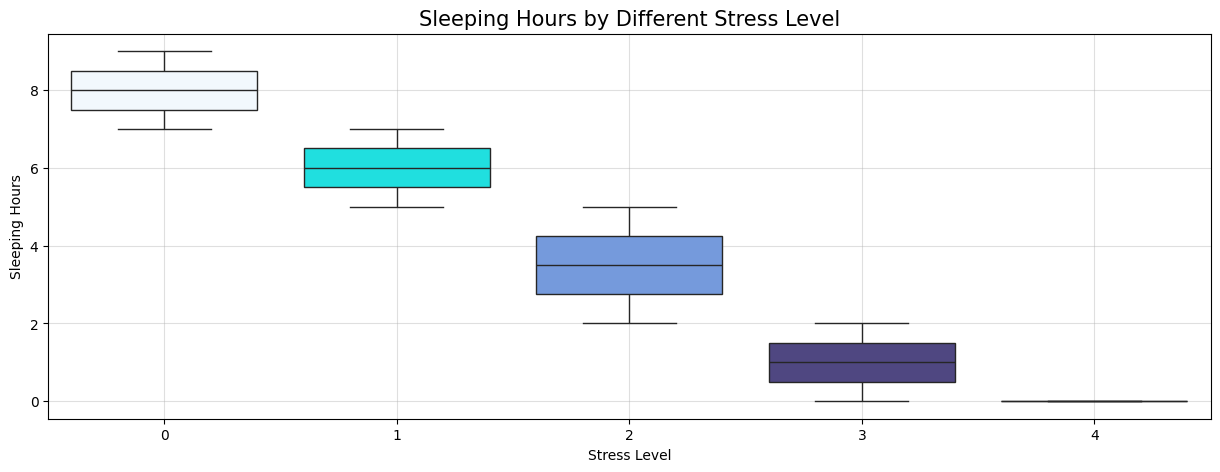

In [15]:
display(data.groupby('StressLevel').SnoringRate.describe())
plt.figure(figsize=(15,5))
sns.boxplot(data=data, y=data['SleepingHours'], x=data['StressLevel'], palette=colors)
plt.xlabel('Stress Level')
plt.ylabel('Sleeping Hours')
plt.title('Sleeping Hours by Different Stress Level', fontsize=15)
plt.grid(alpha=0.4)
plt.show()

,count,mean,std,min,25%,50%,75%,max
StressLevel,,,,,,,,
0,126.0,47.5,1.460685,45.0,46.25,47.5,48.75,50.0
1,126.0,55.0,2.921370,50.0,52.50,55.0,57.50,60.0
2,126.0,70.0,5.842739,60.0,65.00,70.0,75.00,80.0
3,126.0,87.5,4.382054,80.0,83.75,87.5,91.25,95.0
4,126.0,98.0,1.168548,96.0,97.00,98.0,99.00,100.0


<ipython-input-16-9f1d9760353c>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, y=data['HeartRate'], x=data['StressLevel'], palette=colors)


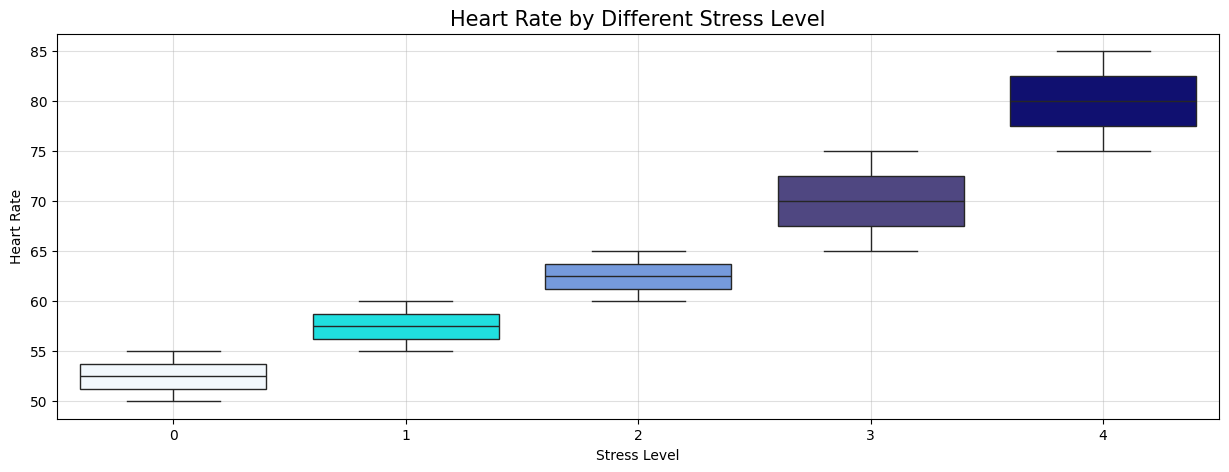

In [16]:
display(data.groupby('StressLevel').SnoringRate.describe())
plt.figure(figsize=(15,5))
sns.boxplot(data=data, y=data['HeartRate'], x=data['StressLevel'], palette=colors)
plt.xlabel('Stress Level')
plt.ylabel('Heart Rate')
plt.title('Heart Rate by Different Stress Level', fontsize=15)
plt.grid(alpha=0.4)
plt.show()


In [17]:
X = data.drop(['StressLevel'], axis=1)
y = data['StressLevel']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the training and testing sets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (504, 8)
y_train shape: (504,)
X_test shape: (126, 8)
y_test shape: (126,)


In [19]:
y_train.shape

(504,)

In [20]:
y_train.values.ravel().shape

(504,)

In [21]:
forest = RandomForestClassifier(n_estimators=500, random_state=1)

# Train the RandomForestClassifier on the training data
forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=1)

In [22]:
importances = forest.feature_importances_

# Loop over each feature and its importance
for i in range(X_train.shape[1]):
    # Print the feature number, name, and importance score
    print("%2d) %-*s %f" % (i + 1, 30, data.columns[i], importances[i]))

 1) SnoringRate                    0.130143
 2) RespirationRate                0.123295
 3) BodyTemperature                0.122216
 4) LimbMovement                   0.123938
 5) BloodOxygen                    0.136199
 6) RapidEyeMovement               0.137116
 7) SleepingHours                  0.104807
 8) HeartRate                      0.122288


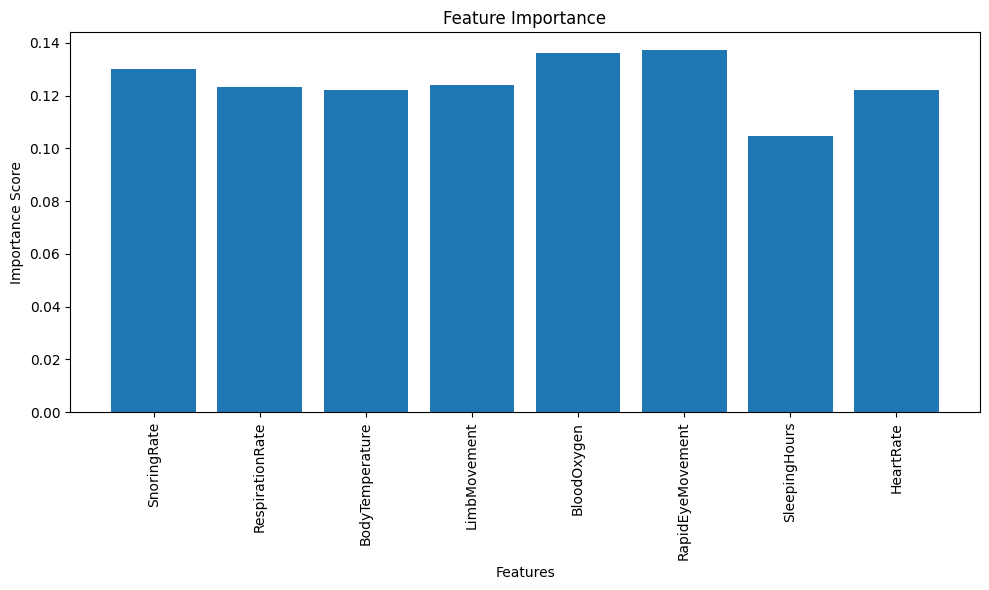

In [23]:
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), importances, align='center')
plt.title('Feature Importance')
plt.xticks(range(X_train.shape[1]), X_train.columns, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()


In [24]:
forest.score(X_test,y_test)

0.9841269841269841

In [25]:
from sklearn.metrics import confusion_matrix
y_predict = forest.predict(X_test)

matrix = confusion_matrix(y_test, y_predict)

print("Confusion Matrix:")
print(matrix)

Confusion Matrix:
[[23  0  0  0  0]
 [ 1 23  0  0  0]
 [ 0  0 28  0  0]
 [ 0  0  0 25  1]
 [ 0  0  0  0 25]]


In [26]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_predict)

# Print the classification report
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        23
           1       1.00      0.96      0.98        24
           2       1.00      1.00      1.00        28
           3       1.00      0.96      0.98        26
           4       0.96      1.00      0.98        25

    accuracy                           0.98       126
   macro avg       0.98      0.98      0.98       126
weighted avg       0.98      0.98      0.98       126



In [27]:
# Predicting Stress Levels
# To predict stress levels for new data, you can use the 'predict' method of the trained model.
# For example, let's assume we have new data in a DataFrame called 'new_data':
new_data = pd.DataFrame([[60.0, 20.0, 92.0, 15.0, 90.0, 95.0, 2.0, 70.0]], columns=X.columns)

# Predict the stress level for the new data
predicted_stress_level = forest.predict(new_data)

# Dictionary to map integer stress levels to human-readable labels
stress_level_labels = {
    0: "Low/Normal",
    1: "Medium Low",
    2: "Medium",
    3: "Medium High",
    4: "High"
}

# Assuming you already have the 'predicted_stress_level' from the previous code snippet
predicted_stress_label = stress_level_labels[predicted_stress_level[0]]

# Display the human-readable label for the predicted stress level
print("Predicted Stress Label for New Data:",predicted_stress_level[0],"(",predicted_stress_label,")")

Predicted Stress Label for New Data: 2 ( Medium )
